In [4]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


import h5py
#from read_raw import load_from_file
import maxlab_analysis as mla
from assay import *

import time
from scipy.signal import find_peaks
import scipy.stats as stats
from scipy.spatial import distance

from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering#SpectralClustering#, HDBSCAN
import seaborn as sns
from umap import UMAP
import umap.plot

from pathlib import Path
from datetime import datetime

import pprint
import pickle



# Load Data

In [5]:
parent_folder = 'D:/'
project_name = 'Summer_2023_Batch_2'

all_network_scans = mla.load_assays_from_project(parent_folder, project_name)

pprint.pprint(all_network_scans)

print(all_network_scans['20439'][1])
print(list(all_network_scans['20439'][1].path.glob('*.*')))



{'16365': [D:\Summer_2023_Batch_2\230705\16365\Network\000002,
           D:\Summer_2023_Batch_2\230706\16365\Network\000023,
           D:\Summer_2023_Batch_2\230710\16365\Network\000050,
           D:\Summer_2023_Batch_2\230712\16365\Network\000061,
           D:\Summer_2023_Batch_2\230718\16365\Network\000082,
           D:\Summer_2023_Batch_2\230725\16365\Network\000143,
           D:\Summer_2023_Batch_2\230801\16365\Network\000171,
           D:\Summer_2023_Batch_2\230803\16365\Network\000179,
           D:\Summer_2023_Batch_2\230809\16365\Network\000191],
 '17763': [],
 '17797': [D:\Summer_2023_Batch_2\230705\17797\Network\000011,
           D:\Summer_2023_Batch_2\230707\17797\Network\000031,
           D:\Summer_2023_Batch_2\230711\17797\Network\000057,
           D:\Summer_2023_Batch_2\230713\17797\Network\000072,
           D:\Summer_2023_Batch_2\230718\17797\Network\000099,
           D:\Summer_2023_Batch_2\230725\17797\Network\000151,
           D:\Summer_2023_Batch_2\230801

In [6]:
#Choose just one assay to look at for now.
assay = all_network_scans['20647'][9]
print(assay)

path: D:\Summer_2023_Batch_2\230719\20647\Network\000102
project: Summer_2023_Batch_2
date: 2023-07-19
chip_number: 20647
assay_type: Network
assay_number: 102



In [7]:
assay.spike_df.head()

,time,channel,amplitude
0,0.0000,917,-19.381773
51,0.1835,1003,-12.189192
54,0.1888,350,-11.355731
63,0.2225,356,-10.831713
67,0.2282,627,-12.123701


In [8]:
t = assay.raw_npy[:, 0]
X = assay.raw_npy[:, 1:]
print(X)
print(t)
# for i, t in enumerate(time_points):
#     for channel in channel_list:
#         if X[i, channel] == 1:
#             plt.scatter(t, channel)

[[0.00327301 0.0032793  0.00338001 ... 0.00334854 0.00332336 0.00322266]
 [0.00329819 0.00327301 0.00338001 ... 0.00334854 0.00332966 0.00322266]
 [0.00331078 0.00326042 0.00338631 ... 0.00334854 0.00333595 0.00322895]
 ...
 [0.00325413 0.00321636 0.00322895 ... 0.00324154 0.00322266 0.00320377]
 [0.00324783 0.00322266 0.00323524 ... 0.00324783 0.00321636 0.00320377]
 [0.00322895 0.00323524 0.00324783 ... 0.00325413 0.00323524 0.00319118]]
[0.000000e+00 8.000000e-04 1.600000e-03 ... 6.000472e+02 6.000480e+02
 6.000488e+02]


# PCA

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

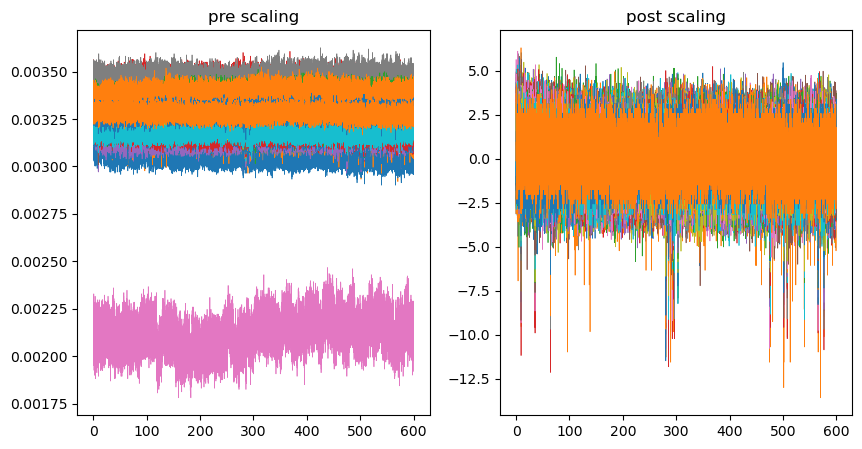

In [10]:
#Plot a subset of the channels
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.plot(t[:], X[:, ::10], linewidth = 0.5)
plt.title('pre scaling')

plt.subplot(122)
plt.plot(t[:], X_scaled[:, ::10], linewidth = 0.5)
plt.title('post scaling')
plt.show()

In [11]:
n_components = 50

pca = PCA(n_components)
X_pca = pca.fit_transform(X_scaled)

print(pca.explained_variance_ratio_)

[0.08721143 0.02786094 0.01160739 0.00710047 0.00553787 0.00414209
 0.00377432 0.00360939 0.00341136 0.0029206  0.00280043 0.00261582
 0.00254839 0.00245255 0.00229418 0.00219652 0.00218744 0.00211749
 0.0020048  0.00196399 0.00192702 0.00189633 0.00188427 0.0018499
 0.00183774 0.00180305 0.00179588 0.00177115 0.00175314 0.00174838
 0.00174027 0.00171989 0.00169715 0.0016918  0.00167408 0.00166525
 0.00165424 0.00164531 0.0016401  0.00163312 0.00162122 0.00159873
 0.00159132 0.00158229 0.00157553 0.00157013 0.00156139 0.00155041
 0.00153983 0.00152203]


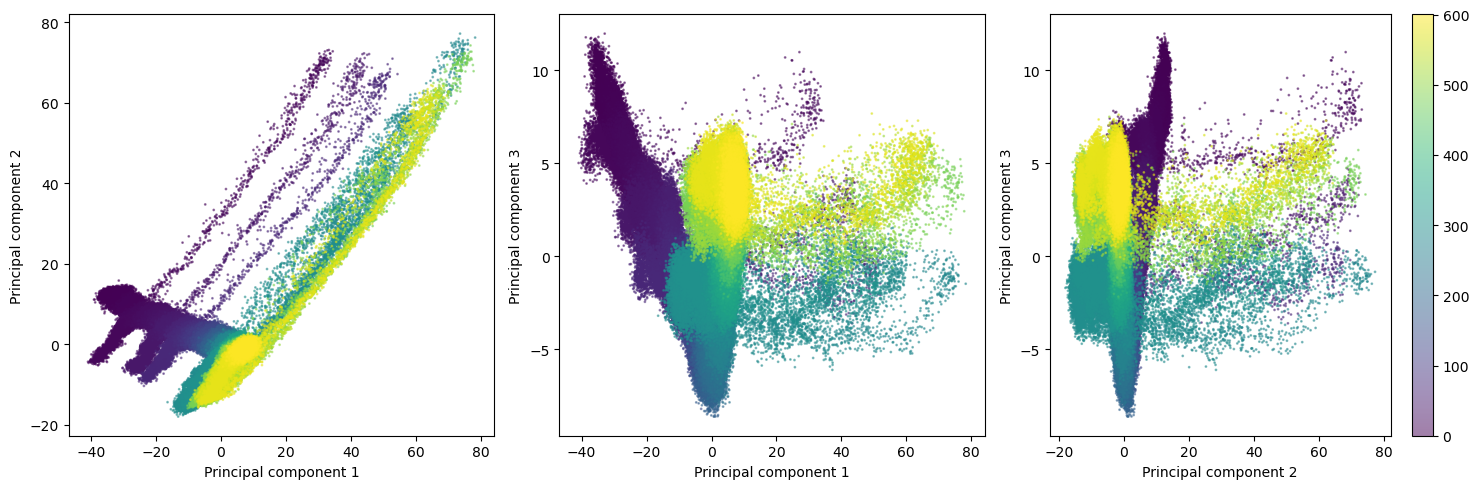

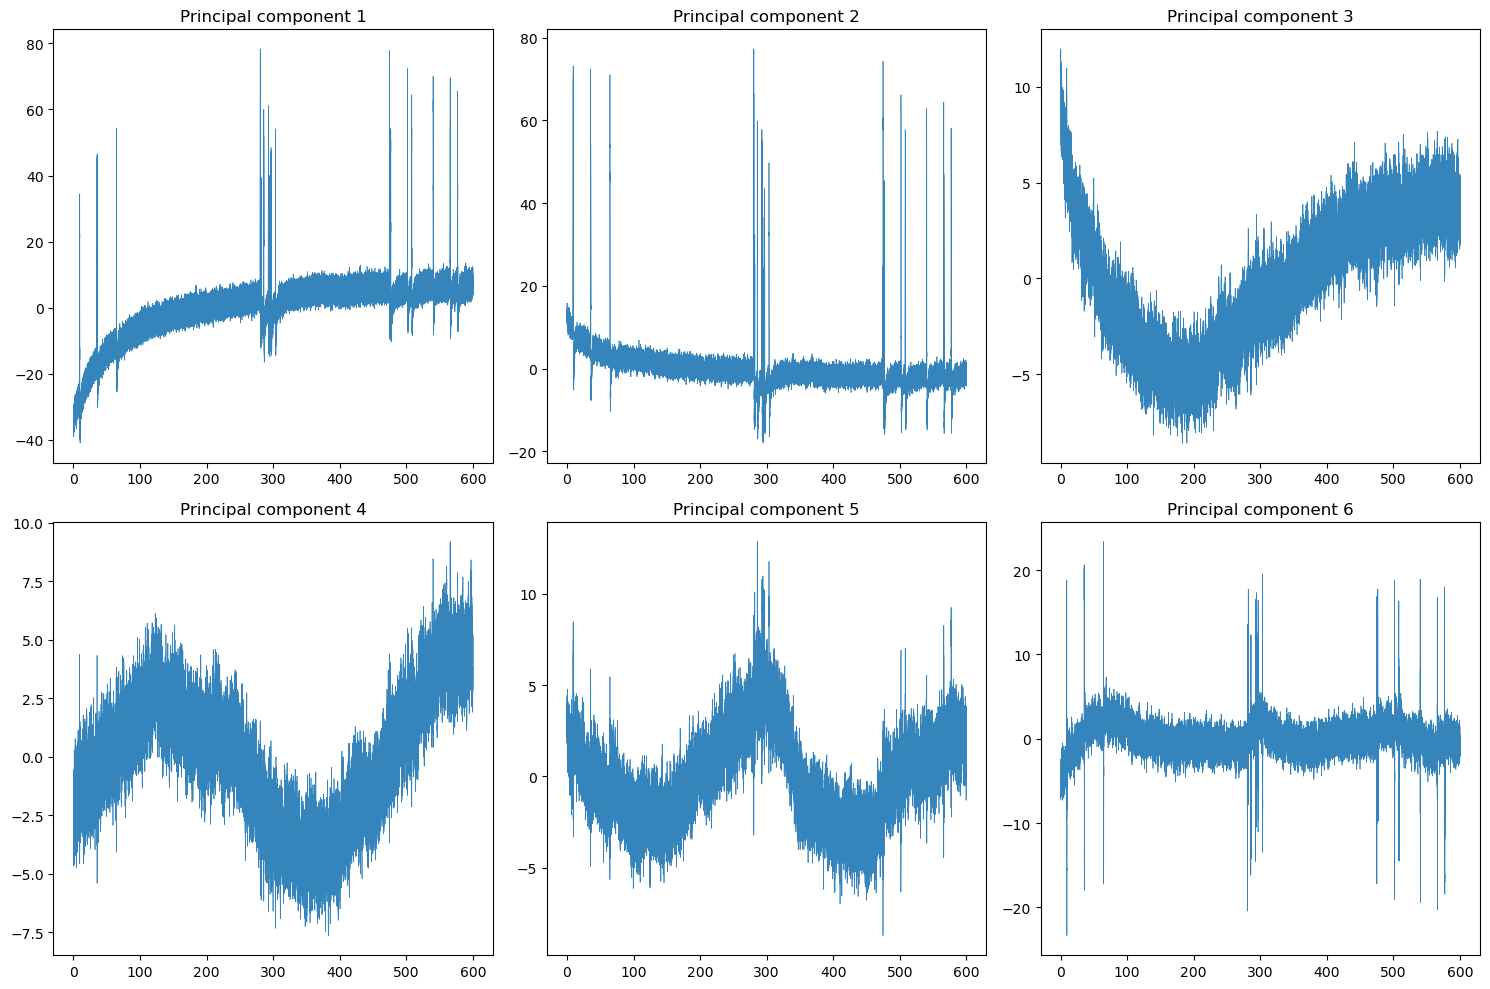

In [12]:
%matplotlib inline
fig = plt.figure(figsize = (15, 5))

plt.subplot(131)

plt.scatter(X_pca[:, 0], X_pca[:, 1],  s = 1, c = t, alpha = 0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

plt.subplot(132)

plt.scatter(X_pca[:, 0], X_pca[:, 2],  s = 1, c = t, alpha = 0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 3')

plt.subplot(133)
plt.scatter(X_pca[:, 1], X_pca[:, 2],  s = 1, c = t, alpha = 0.5)
plt.colorbar()
plt.xlabel('Principal component 2')
plt.ylabel('Principal component 3')
plt.tight_layout()
plt.show()

fig_width = 3

num_figs = 6
plt.figure(figsize = (fig_width * 5, (int(np.ceil(num_figs/fig_width)) * 5)))
for i in np.arange(1, num_figs + 1):
    plt.subplot(int(np.ceil(num_figs/fig_width)), fig_width, i)
    plt.plot(t, X_pca[:, i-1], linewidth = 0.5, alpha = 0.9)
    plt.title('Principal component ' + str(i))
plt.tight_layout()
plt.show()

# UMAP

In [13]:
subsample = 5

X_umap = list()
neighbors = np.arange(100, 1500, 200)
min_dists = [0.2, 0.5]
for i, neighbor in enumerate(neighbors):
    X_umap.append(list())
    for j, min_dist in enumerate(min_dists):
        s = time.time()
        map = UMAP(n_neighbors= neighbor, min_dist = min_dist)
        X_umap[i].append(map.fit_transform(X_scaled[::subsample]))

        print('done ' + str(neighbor) + ' neighbors, ' + str(min_dist) + ' min_dist: t = ' + str(time.time() - s))

done 100 neighbors, 0.2 min_dist: t = 1380.1974604129791
done 100 neighbors, 0.5 min_dist: t = 2170.145657300949
done 300 neighbors, 0.2 min_dist: t = 757.2983016967773
done 300 neighbors, 0.5 min_dist: t = 768.2779476642609
done 500 neighbors, 0.2 min_dist: t = 1058.0643339157104
done 500 neighbors, 0.5 min_dist: t = 1037.2707993984222
done 700 neighbors, 0.2 min_dist: t = 1373.8118164539337
done 700 neighbors, 0.5 min_dist: t = 1384.8080971240997
done 900 neighbors, 0.2 min_dist: t = 1958.9498007297516
done 900 neighbors, 0.5 min_dist: t = 1950.0187990665436
done 1100 neighbors, 0.2 min_dist: t = 2176.568330526352
done 1100 neighbors, 0.5 min_dist: t = 2314.415969848633
done 1300 neighbors, 0.2 min_dist: t = 2543.264725446701
done 1300 neighbors, 0.5 min_dist: t = 2700.3616528511047


In [14]:
print(X_umap)

[[array([[  8.947456 , -14.472791 ],
       [  8.964468 , -14.491096 ],
       [  8.976989 , -14.486433 ],
       ...,
       [ 12.565525 ,   7.8176928],
       [ 12.561081 ,   7.807938 ],
       [ 12.565312 ,   7.818799 ]], dtype=float32), array([[ -2.0762784 , -15.760234  ],
       [ -2.1854856 , -15.686704  ],
       [ -2.1536405 , -15.613427  ],
       ...,
       [ -0.16903977,   4.923255  ],
       [ -0.13481817,   4.9244146 ],
       [ -0.15047337,   4.891466  ]], dtype=float32)], [array([[-4.065293 , -7.0331845],
       [-4.0839143, -7.0480237],
       [-4.0707374, -7.0909047],
       ...,
       [ 6.1226068, -3.5800033],
       [ 6.1644354, -3.6014252],
       [ 6.1250515, -3.582799 ]], dtype=float32), array([[-4.067308 , -7.7559595],
       [-4.116498 , -7.828686 ],
       [-4.278957 , -7.9127707],
       ...,
       [ 7.696299 , -3.5273938],
       [ 7.8091183, -3.6766748],
       [ 7.651545 , -3.5824609]], dtype=float32)], [array([[-3.9181306, -3.3777711],
       [-3.937476

In [54]:
plt.figure(figsize = (20, 20))
#neighbors = np.arange(10, 300, 40)
for i, arr in enumerate(X_umap):
    
    plt.subplot(5, 6, i + 1)
    plt.scatter(X_umap[i + 1][:, 0], X_umap[i + 1][:, 1], s = 0.4, alpha = 0.5, c = t)
    plt.title('umap')

plt.tight_layout()
plt.show()

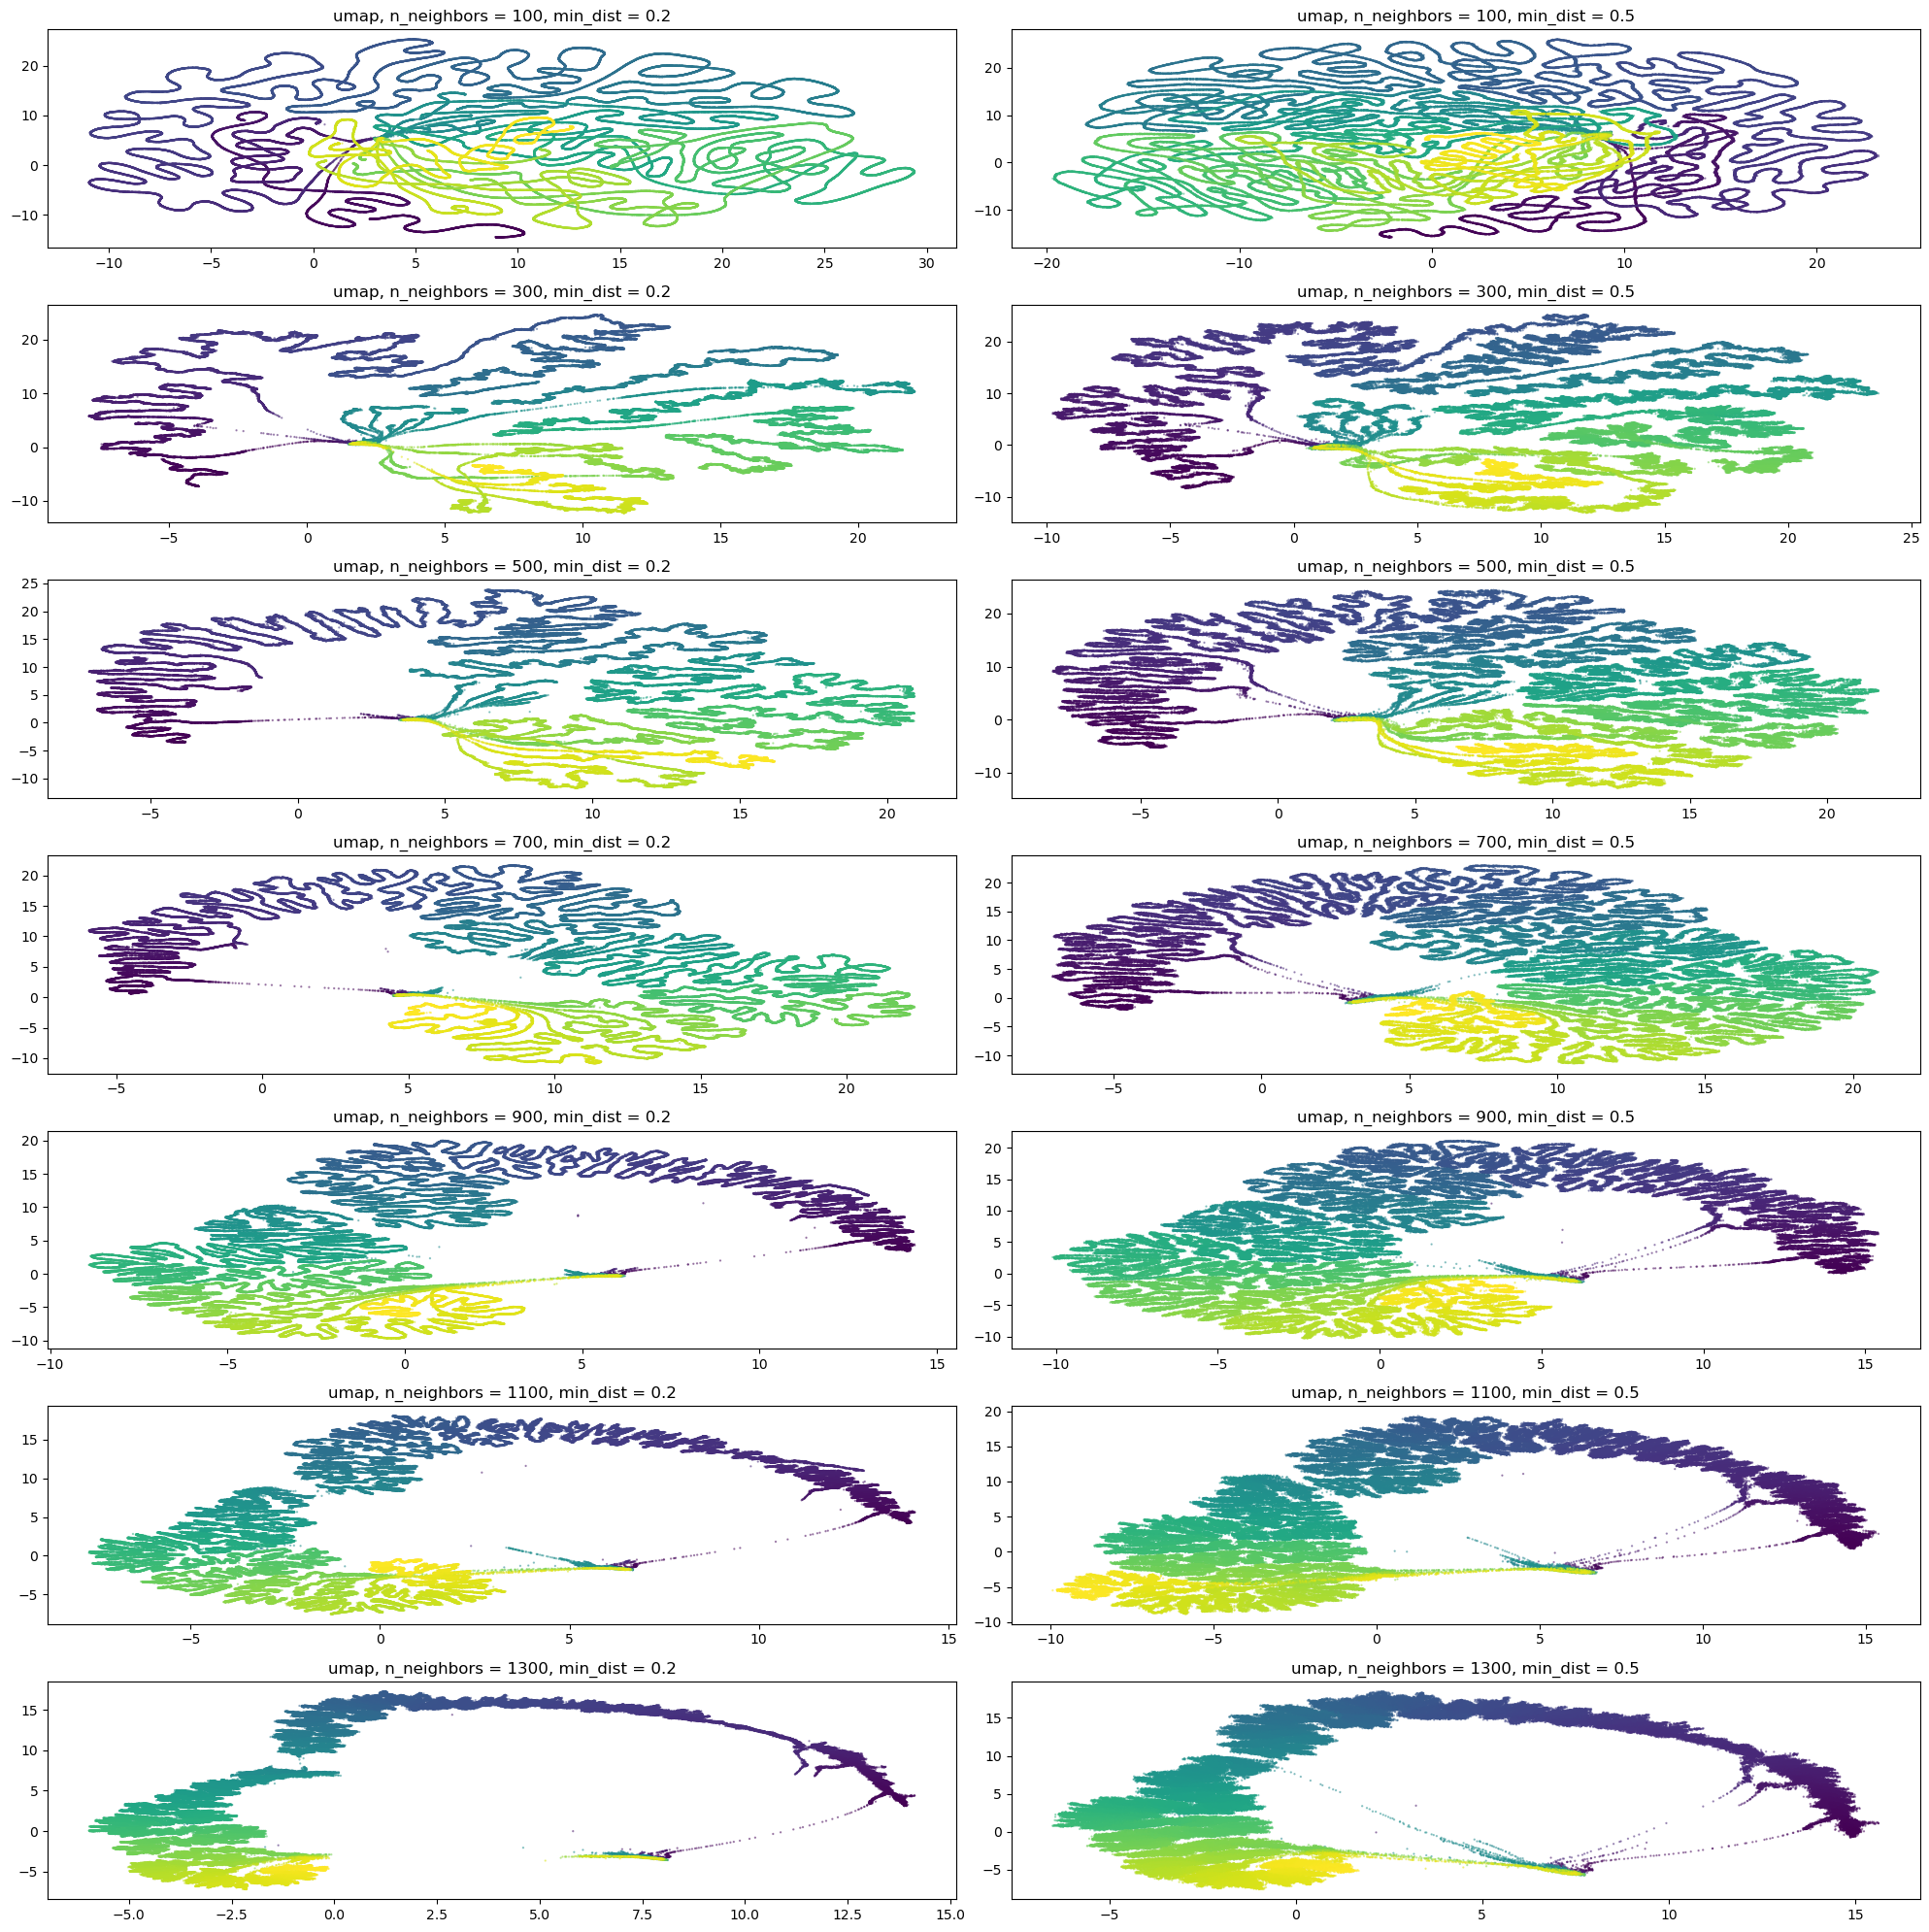

In [18]:
plt.figure(figsize = (20, 20))
#neighbors = np.arange(10, 300, 40)


for i, neighbor in enumerate(neighbors):
    for j, min_dist in enumerate(min_dists):
        plt.subplot(len(neighbors), len(min_dists), i * (len(min_dists)) + j + 1)
        plt.scatter(X_umap[i][j][:, 0], X_umap[i][j][:, 1], s = 0.4, alpha=0.5, c = t[::subsample])
        plt.title('umap, n_neighbors = ' + str(neighbor) + ', min_dist = ' + str(min_dist))

plt.tight_layout()
plt.show()

In [19]:
with open(r"umap_100-1300.pickle", "wb") as output_file:
     pickle.dump(X_umap, output_file)

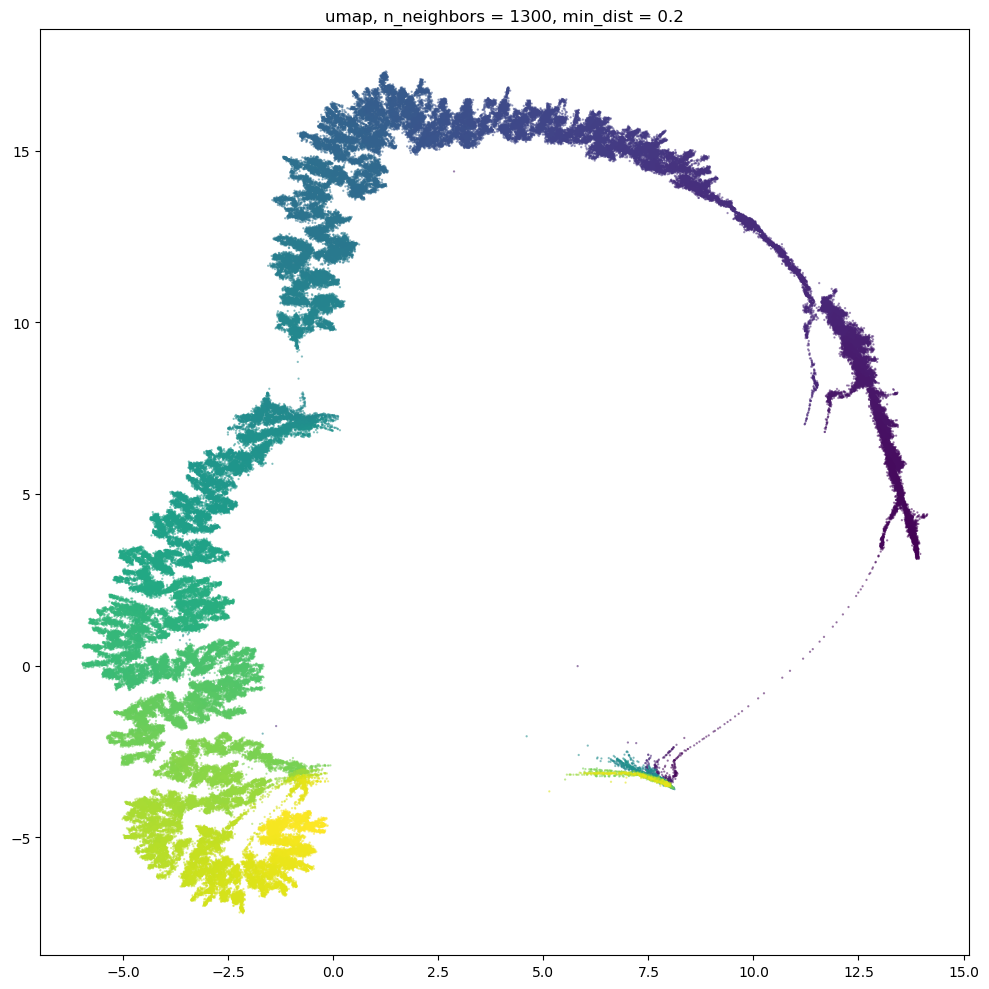

In [24]:
plt.figure(figsize = (10, 10))
#neighbors = np.arange(10, 300, 40)
plt.scatter(X_umap[6][0][:, 0], X_umap[6][0][:, 1], s = 0.4, alpha=0.5, c = t[::subsample])
plt.title('umap, n_neighbors = ' + str(neighbors[6]) + ', min_dist = ' + str(min_dists[0]))

plt.tight_layout()
plt.show()

In [27]:
print(map)
s = time.time()
full_transformed = map.transform(X_scaled)
print('t = ' + str(time.time() - s))

UMAP(min_dist=0.5, n_neighbors=1300, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})
